In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import random
import zipfile
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

random.seed(1)# setting random seed
main_data = pd.read_csv('./Image_classification_data (1)/data_labels_mainData.csv')

2023-05-05 16:03:01.989748: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
main_data['patientID'].value_counts()

54    389
29    355
9     348
8     332
20    325
18    320
17    310
10    302
51    286
55    263
23    254
7     253
41    250
21    224
40    209
14    207
6     198
50    195
24    192
49    187
13    180
25    180
52    178
5     169
33    163
58    161
19    158
26    157
22    152
57    149
48    147
43    137
31    137
42    136
3     136
47    133
53    132
12    130
36    128
4     127
15    125
44    121
46    120
59    115
60    115
16    111
30    110
39    105
32     99
56     92
38     84
45     74
37     71
11     56
2      33
1      19
27     17
28     15
34     14
35     11
Name: patientID, dtype: int64

In [3]:
cancerTypes = ['epithelial', 'inflammatory', 'fibroblast', 'others']

one_hot = pd.get_dummies(main_data['cellTypeName'])
main_data = main_data.drop('cellTypeName',axis = 1)
main_data = main_data.join(one_hot)
main_data

# https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python

,InstanceID,patientID,ImageName,cellType,isCancerous,epithelial,fibroblast,inflammatory,others
0,22405,1,22405.png,0,0,0,1,0,0
1,22406,1,22406.png,0,0,0,1,0,0
2,22407,1,22407.png,0,0,0,1,0,0
3,22408,1,22408.png,0,0,0,1,0,0
4,22409,1,22409.png,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
9891,1625,60,1625.png,2,1,1,0,0,0
9892,1626,60,1626.png,2,1,1,0,0,0
9893,1627,60,1627.png,2,1,1,0,0,0
9894,1628,60,1628.png,2,1,1,0,0,0


In [4]:
main_data.isnull().sum()

InstanceID      0
patientID       0
ImageName       0
cellType        0
isCancerous     0
epithelial      0
fibroblast      0
inflammatory    0
others          0
dtype: int64

In [5]:
from sklearn.model_selection import GroupShuffleSplit 

splitter = GroupShuffleSplit(n_splits=5,train_size=.7, random_state=42)
split = splitter.split(main_data, groups=main_data['patientID'])
splitter.get_n_splits()

# train_inds, test_inds = next(split)

# train_data = main_data.iloc[train_inds]
# test_data = main_data.iloc[test_inds]
# train_data

5

In [6]:
X = main_data.drop(columns=["isCancerous"])
y = main_data["isCancerous"]

gs_1 = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=42)
train_test_ix, val_ix = next(gs_1.split(X, y, groups=main_data["patientID"]))
X_train_test = X.loc[train_test_ix]
X_val = X.loc[val_ix]
y_train_test = y.loc[train_test_ix]
y_val = y.loc[val_ix]

X_train_test = X_train_test.reset_index(drop=True)
y_train_test = y_train_test.reset_index(drop=True)
gs_2 = GroupShuffleSplit(n_splits=1, train_size=.75, random_state=42)
train_ix, test_ix = next(gs_2.split(X_train_test, y_train_test, groups=X_train_test["patientID"]))
X_train = X_train_test.loc[train_ix]
X_test = X_train_test.loc[test_ix]
y_train = y.loc[train_ix]
y_test = y.loc[test_ix]

# https://stackoverflow.com/questions/68152473/python-split-to-train-test-val-using-groupshufflesplit

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.]),
 [Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0, 0, '1.0'),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

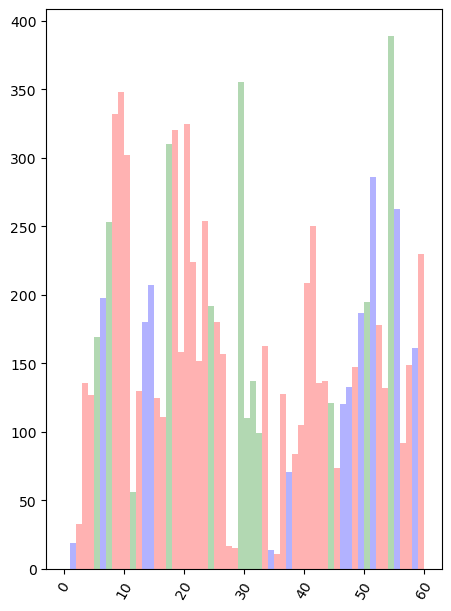

In [9]:
plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.tight_layout(pad=4.0)
plt.hist(x=X_train['patientID'], alpha=0.3, color='r', bins=60,range=(0,60))
plt.hist(x=X_val['patientID'], alpha=0.3, color='b', bins=60, range=(0,60))
plt.hist(x=X_test['patientID'], alpha=0.3, color='g', bins=60, range=(0,60))
# plt.hist(x=train_data['patientID'], alpha=0.3, color='b', bins=60, align='left')
plt.xticks(rotation=60)

In [ ]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 10

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [ ]:
model.summary()